# Data Exploration Notebook

## Andrew Taylor
## atayl136

This notebook demonstrates loading the MovieLens dataset, partitioning it, and visualizing rating and timestamp distributions.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd

def load_dataset(path: str = 'storage/u.data') -> pd.DataFrame:
    """
    Load the MovieLens-style dataset and print out basic structural info.

    Parameters
    ----------
    path : str, default='storage/u.data'
        Path to the tab-separated file containing columns
        ['user', 'item', 'rating', 'timestamp'].

    Returns
    -------
    df : pd.DataFrame
        The loaded dataset.
    """
    # Load the data
    df = pd.read_csv(
        path,
        sep='\t',
        names=['user', 'item', 'rating', 'timestamp'],
        dtype={'user': int, 'item': int, 'rating': float, 'timestamp': int}
    )

    # Display structure
    print(f"Dataset loaded from {path!r}")
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")

    print("Columns:")
    for col in df.columns:
        print(f"  - {col} ({df[col].dtype})")
    print()

    print("First 5 rows:")
    print(df.head(), "\n")

    print("DataFrame info:")
    df.info()
    print()

    print("Descriptive statistics (numeric columns):")
    print(df.describe(), "\n")

    return df

# usage:
df = load_dataset()
print(df.head())

Dataset loaded from 'storage/u.data'
Shape: 100000 rows, 4 columns

Columns:
  - user (int32)
  - item (int32)
  - rating (float64)
  - timestamp (int32)

First 5 rows:
   user  item  rating  timestamp
0   196   242     3.0  881250949
1   186   302     3.0  891717742
2    22   377     1.0  878887116
3   244    51     2.0  880606923
4   166   346     1.0  886397596 

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user       100000 non-null  int32  
 1   item       100000 non-null  int32  
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  int32  
dtypes: float64(1), int32(3)
memory usage: 1.9 MB

Descriptive statistics (numeric columns):
               user           item         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130     

In [2]:
from sklearn.model_selection import train_test_split

def partition_data(
    df,
    test_size: float = 0.2,
    random_state: int = 42,
    method: str = "user_stratified",
    time_column: str = None
):
    """
    Split a DataFrame into train and test sets.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset containing at least a 'user' column (for stratification)
        and, if using temporal sampling, a datetime column.
    test_size : float or int, default=0.2
        If float, fraction of data to reserve for test; if int, absolute number
        of test samples.
    random_state : int, default=42
        Seed for reproducibility (only used for stratified sampling).
    method : {'user_stratified', 'temporal'}, default='user_stratified'
        - 'user_stratified': randomly splits so each user’s proportion is preserved.
        - 'temporal': splits by time, train = earliest (1 - test_size), test = latest test_size.
    time_column : str, default=None
        Name of the datetime column to sort on when method='temporal'. Required in that case.

    Returns
    -------
    train_df, test_df : pd.DataFrame
        The training and testing partitions.
    """
    if method == "user_stratified":
        if "user" not in df.columns:
            raise KeyError("DataFrame must have a 'user' column for stratified sampling.")
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=df["user"]
        )

    elif method == "temporal":
        if time_column is None:
            raise ValueError("`time_column` must be provided for temporal sampling.")
        if time_column not in df.columns:
            raise KeyError(f"DataFrame has no column '{time_column}'.")
        # ensure it's datetime
        df_sorted = df.sort_values(by=time_column)
        n = len(df_sorted)
        # compute number of test rows
        n_test = int(n * test_size) if isinstance(test_size, float) else test_size
        train_df = df_sorted.iloc[:-n_test].reset_index(drop=True)
        test_df  = df_sorted.iloc[-n_test:].reset_index(drop=True)

    else:
        raise ValueError("`method` must be 'user_stratified' or 'temporal'.")

    print(f"Train size: {len(train_df)}  |  Test size: {len(test_df)}")
    return train_df, test_df


Train size: 80000  |  Test size: 20000


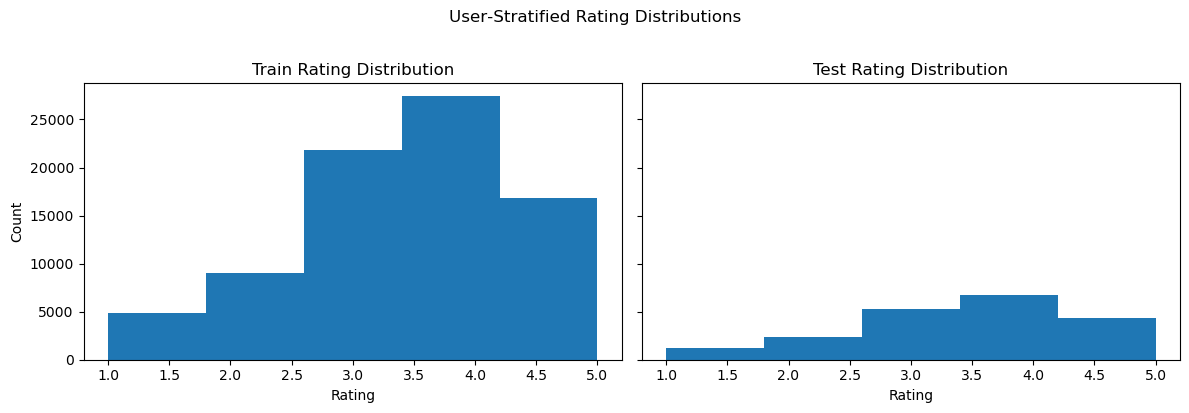

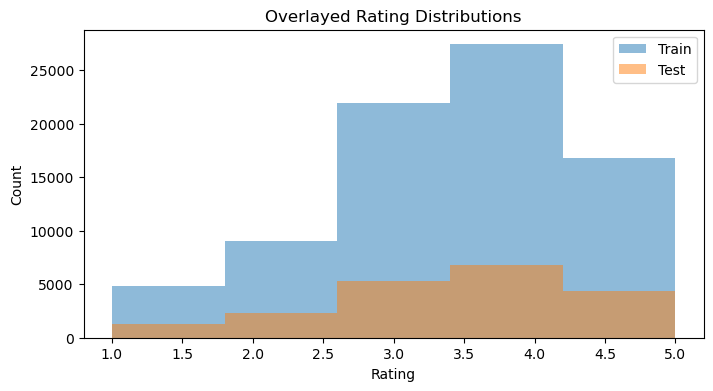

In [3]:

import matplotlib.pyplot as plt

# 1) Split using our helper
train_df, test_df = partition_data(
    df,
    test_size=0.2,
    method="user_stratified"
)

# 2) Plot side‐by‐side distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(train_df['rating'], bins=5)
axes[0].set_title('Train Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

axes[1].hist(test_df['rating'], bins=5)
axes[1].set_title('Test Rating Distribution')
axes[1].set_xlabel('Rating')

plt.suptitle('User‑Stratified Rating Distributions', y=1.02)
plt.tight_layout()
plt.show()

# 3) (Optional) Overlay both for direct comparison
plt.figure(figsize=(8, 4))
plt.hist(train_df['rating'], bins=5, alpha=0.5, label='Train')
plt.hist(test_df['rating'],  bins=5, alpha=0.5, label='Test')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Overlayed Rating Distributions')
plt.legend()
plt.show()



Train size: 80000  |  Test size: 20000


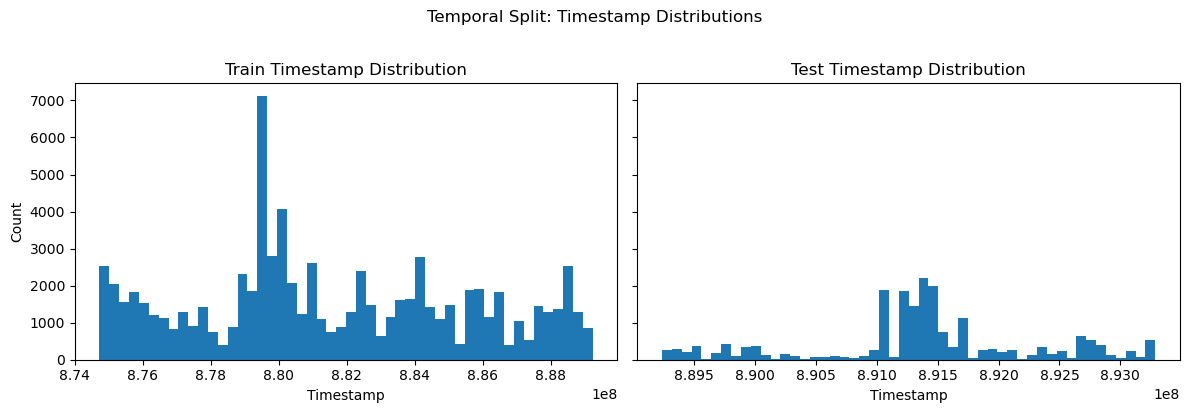

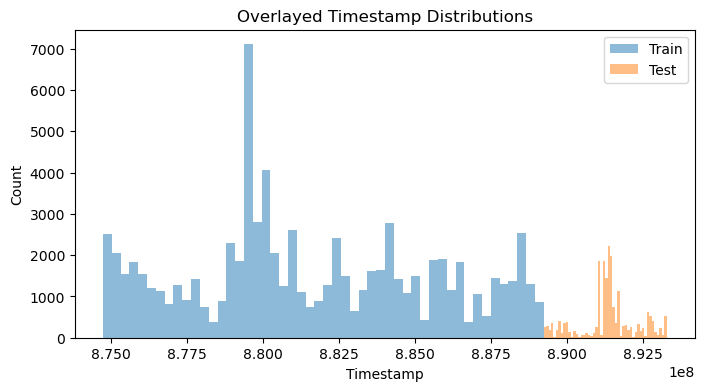

In [4]:

import matplotlib.pyplot as plt

# 1) Temporal split with 20% test data
train_df, test_df = partition_data(
    df,
    test_size=0.2,
    method="temporal",
    time_column="timestamp"
)

# 2) Plot side‑by‑side timestamp distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(train_df['timestamp'], bins=50)
axes[0].set_title('Train Timestamp Distribution')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Count')

axes[1].hist(test_df['timestamp'], bins=50)
axes[1].set_title('Test Timestamp Distribution')
axes[1].set_xlabel('Timestamp')

plt.suptitle('Temporal Split: Timestamp Distributions', y=1.02)
plt.tight_layout()
plt.show()

# 3) Optional: overlayed histograms for direct comparison
plt.figure(figsize=(8, 4))
plt.hist(train_df['timestamp'], bins=50, alpha=0.5, label='Train')
plt.hist(test_df['timestamp'],  bins=50, alpha=0.5, label='Test')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Overlayed Timestamp Distributions')
plt.legend()
plt.show()
